## Готовим данные

In [1]:
import numpy as np
import torch
import torchvision
from tqdm.notebook import tqdm
from torch import nn
from torch.nn import functional as F
from sklearn.metrics import accuracy_score

import torch
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader

In [2]:
from torchvision.datasets.cifar import CIFAR100

full_train_dataset = CIFAR100(root='./data', train=True, download=True)
train_dataset, val_dataset = torch.utils.data.random_split(full_train_dataset, [45000, 5000])

test_dataset = CIFAR100(root='./data', train=False, download=True)

print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
45000
5000
10000


## Файнтюним модели

In [3]:
transform_1 = T.Compose([
  #  T.ToPILImage(),
  #  T.Resize(256),
  #  T.CenterCrop(256),
   T.ToTensor(),
   T.Normalize(
       mean=[0.485, 0.456, 0.406],
       std=[0.229, 0.224, 0.225]
   )
])

transform_2 = T.Compose([
  #  T.ToPILImage(),
  #  T.Resize(256),
  #  T.CenterCrop(256),
   T.RandomHorizontalFlip(),
   T.ToTensor(),
   T.Normalize(
       mean=[0.485, 0.456, 0.406],
       std=[0.229, 0.224, 0.225]
   )
])

transform_3 = T.Compose([
  #  T.ToPILImage(),
  #  T.Resize(256),
  #  T.CenterCrop(256),
   T.RandomHorizontalFlip(),
   T.RandomRotation([-15, 15]),
   T.ToTensor(),
   T.Normalize(
       mean=[0.485, 0.456, 0.406],
       std=[0.229, 0.224, 0.225]
   )
])

transforms = {
    'no_transform': transform_1,
    'with_flip': transform_2,
    'with_rotation': transform_3,
}

In [12]:
def train_one_epoch(model, train_dataloader, criterion, optimizer, device="cuda:0"):
    progress_bar = tqdm(train_dataloader)
    model = model.to(device).train()
    idx = 0
    for (images, labels) in progress_bar:
        images, labels = images.to(device), labels.to(device)
        preds = model(images)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if idx % 10 == 0:
            progress_bar.set_description("Loss = {:.4f}".format(loss.item()))
        idx += 1

def predict(model, val_dataloader, criterion, device="cuda:0"):
    model = model.to(device).eval()
    loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        idx = 0
        for (images, labels) in val_dataloader: 
            idx += 1
            images, labels = images.to(device), labels.to(device)
            preds = model(images)
            loss += criterion(preds, labels)
            all_preds += [preds]
            all_labels += [labels]
    torch.vstack(all_preds)
    
    return loss, torch.vstack(all_preds), torch.cat(all_labels)

def train(model, train_dataloader, val_dataloader, criterion, optimizer, device="cuda:0", n_epochs=10, scheduler=None):
    model = model.to(device)
    for epoch in range(n_epochs):
        train_one_epoch(model, train_dataloader, criterion, optimizer, device)
        loss, preds, labels = predict(model, val_dataloader, criterion, device)
        preds = preds.argmax(axis=-1)
        print(f"Val accuracy: {(preds == labels).sum() / preds.shape[0]}")

        if scheduler is not None:
            scheduler.step()

In [ ]:
full_train_dataset = CIFAR100(root='./data', train=True, download=True, transform=transform_1)
train_dataset, val_dataset = torch.utils.data.random_split(full_train_dataset, [45000, 5000])

test_dataset = CIFAR100(root='./data', train=False, download=True, transform=transform_1)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
from torchvision.models import resnet50
from torchvision.models import ResNet50_Weights

model = resnet50(weights=ResNet50_Weights.DEFAULT)
model.fc = nn.Sequential(
    nn.Linear(2048, 100),
)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)
# optimizer = torch.optim.SGD(model.parameters(), lr=3e-3, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = nn.CrossEntropyLoss()

n_epochs = 5
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

cuda:0


In [ ]:
train(model, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs, scheduler)

  0%|          | 0/704 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
from os import listdir
from os.path import isfile, join

transforms_names = ['no_transform', 'with_rotation', 'with_flip']
seeds = [42, 777, 1337]
lrs = [1e-4, 5e-4, 1e-3, 1e-5, 5e-5]

has_models = [f for f in listdir('./final_models') if isfile(join('./final_models', f))]
print(has_models)

torch.backends.cudnn.deterministic = True

for seed in seeds:
    for transform in transforms_names:
        for lr in lrs:
            model_name = f'resnet50_seed_{seed}_transform_{transform}_lr_{lr}.pth'
            if model_name in has_models:
                print(model_name + ' already tuned!')
                continue

            full_train_dataset = CIFAR100(root='./data', train=True, download=True, transform=transforms[transform])
            train_dataset, val_dataset = torch.utils.data.random_split(full_train_dataset, [45000, 5000])

            test_dataset = CIFAR100(root='./data', train=False, download=True, transform=transform_1)

            torch.manual_seed(seed)
            torch.cuda.manual_seed(seed)
            np.random.seed(seed)

            train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
            val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
            test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

            model = resnet50(weights=ResNet50_Weights.DEFAULT)
            model.fc = nn.Sequential(
                nn.Linear(2048, 100),
            )

            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)
            # optimizer = torch.optim.SGD(model.parameters(), lr=3e-3, momentum=0.9, weight_decay=5e-4)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
            criterion = nn.CrossEntropyLoss()

            n_epochs = 20
            device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

            print(f'Train seed={seed}, transform={transform}, lr={lr}')
            train(model, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs, scheduler)
            torch.save(model, f'./final_models/resnet50_seed_{seed}_transform_{transform}_lr_{lr}.pth')
            print(f'Done seed={seed}, transform={transform}, lr={lr}')

['resnet50_seed_777_transform_with_rotation_lr_0.0001.pth', 'resnet50_seed_42_transform_with_flip_lr_0.0001.pth', 'resnet50_seed_42_transform_no_transform_lr_0.0005.pth', 'resnet50_seed_1337_transform_no_transform_lr_0.001.pth', 'resnet50_seed_777_transform_no_transform_lr_0.0005.pth', 'resnet50_seed_42_transform_with_rotation_lr_0.001.pth', 'resnet50_seed_42_transform_with_flip_lr_5e-05.pth', 'resnet50_seed_42_transform_with_rotation_lr_0.0005.pth', 'resnet50_seed_42_transform_with_rotation_lr_0.0001.pth', 'resnet50_seed_42_transform_with_rotation_lr_5e-05.pth', 'resnet50_seed_777_transform_no_transform_lr_0.001.pth', 'resnet50_seed_1337_transform_with_flip_lr_0.0001.pth', 'resnet50_seed_1337_transform_with_rotation_lr_0.0005.pth', 'resnet50_seed_1337_transform_with_flip_lr_0.001.pth', 'resnet50_seed_1337_transform_no_transform_lr_0.0005.pth', 'resnet50_seed_1337_transform_with_flip_lr_0.0005.pth', 'resnet50_seed_777_transform_with_flip_lr_0.0001.pth', 'resnet50_seed_42_transform_with

  0%|          | 0/704 [00:00<?, ?it/s]

Val accuracy: 0.3619999885559082


  0%|          | 0/704 [00:00<?, ?it/s]

Val accuracy: 0.5083999633789062


  0%|          | 0/704 [00:00<?, ?it/s]

Val accuracy: 0.553600013256073


  0%|          | 0/704 [00:00<?, ?it/s]

Val accuracy: 0.5805999636650085


  0%|          | 0/704 [00:00<?, ?it/s]

Val accuracy: 0.5934000015258789


  0%|          | 0/704 [00:00<?, ?it/s]

Val accuracy: 0.6123999953269958


  0%|          | 0/704 [00:00<?, ?it/s]

Val accuracy: 0.6107999682426453


  0%|          | 0/704 [00:00<?, ?it/s]

Val accuracy: 0.6103999614715576


  0%|          | 0/704 [00:00<?, ?it/s]

Val accuracy: 0.625


  0%|          | 0/704 [00:00<?, ?it/s]

Val accuracy: 0.6236000061035156


  0%|          | 0/704 [00:00<?, ?it/s]

Val accuracy: 0.6243999600410461


  0%|          | 0/704 [00:00<?, ?it/s]

Val accuracy: 0.6283999681472778


  0%|          | 0/704 [00:00<?, ?it/s]

Val accuracy: 0.6304000020027161


  0%|          | 0/704 [00:00<?, ?it/s]

Val accuracy: 0.6269999742507935


  0%|          | 0/704 [00:00<?, ?it/s]

Val accuracy: 0.6225999593734741


  0%|          | 0/704 [00:00<?, ?it/s]

Val accuracy: 0.6283999681472778


  0%|          | 0/704 [00:00<?, ?it/s]

Val accuracy: 0.621999979019165


  0%|          | 0/704 [00:00<?, ?it/s]

Val accuracy: 0.628600001335144


  0%|          | 0/704 [00:00<?, ?it/s]

Val accuracy: 0.6273999810218811


  0%|          | 0/704 [00:00<?, ?it/s]

In [ ]:
! zip -r final_models5.zip final_models

  adding: final_models/ (stored 0%)
  adding: final_models/resnet50_seed_777_transform_with_rotation_lr_0.0001.pth (deflated 7%)
  adding: final_models/resnet50_seed_42_transform_with_flip_lr_0.0001.pth (deflated 7%)
  adding: final_models/resnet50_seed_42_transform_no_transform_lr_0.0005.pth (deflated 7%)
  adding: final_models/resnet50_seed_1337_transform_no_transform_lr_0.001.pth (deflated 7%)
  adding: final_models/resnet50_seed_777_transform_no_transform_lr_0.0005.pth (deflated 7%)
  adding: final_models/resnet50_seed_42_transform_with_rotation_lr_0.001.pth (deflated 7%)
  adding: final_models/resnet50_seed_42_transform_with_flip_lr_5e-05.pth (deflated 7%)
  adding: final_models/resnet50_seed_42_transform_with_rotation_lr_0.0005.pth (deflated 7%)
  adding: final_models/resnet50_seed_42_transform_with_rotation_lr_0.0001.pth (deflated 7%)
  adding: final_models/resnet50_seed_42_transform_with_rotation_lr_5e-05.pth (deflated 7%)
  adding: final_models/resnet50_seed_777_transform_no_t

In [ ]:
! du -sh models.zip

2.3G	models.zip


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil

In [ ]:
shutil.copy("final_models5.zip","/content/drive/MyDrive/final_models5.zip")

'/content/drive/MyDrive/final_models4.zip'

In [5]:
! ls /content/drive/MyDrive/

'Colab Notebooks'   final_models2.zip   final_models4.zip   models.zip
 data		    final_models3.zip   final_models.zip


In [6]:
! unzip /content/drive/MyDrive/final_models4.zip

Archive:  /content/drive/MyDrive/final_models4.zip
   creating: final_models/
  inflating: final_models/resnet50_seed_777_transform_with_rotation_lr_0.0001.pth  
  inflating: final_models/resnet50_seed_42_transform_with_flip_lr_0.0001.pth  
  inflating: final_models/resnet50_seed_42_transform_no_transform_lr_0.0005.pth  
  inflating: final_models/resnet50_seed_1337_transform_no_transform_lr_0.001.pth  
  inflating: final_models/resnet50_seed_777_transform_no_transform_lr_0.0005.pth  
  inflating: final_models/resnet50_seed_42_transform_with_rotation_lr_0.001.pth  
  inflating: final_models/resnet50_seed_42_transform_with_flip_lr_5e-05.pth  
  inflating: final_models/resnet50_seed_42_transform_with_rotation_lr_0.0005.pth  
  inflating: final_models/resnet50_seed_42_transform_with_rotation_lr_0.0001.pth  
  inflating: final_models/resnet50_seed_42_transform_with_rotation_lr_5e-05.pth  
  inflating: final_models/resnet50_seed_777_transform_no_transform_lr_0.001.pth  
  inflating: final_mo

## Model soups

In [7]:
torch.manual_seed(1234)
torch.cuda.manual_seed(1234)
np.random.seed(1234)

full_train_dataset = CIFAR100(root='./data', train=True, download=True, transform=transform_1)
train_dataset, val_dataset = torch.utils.data.random_split(full_train_dataset, [45000, 5000])

test_dataset = CIFAR100(root='./data', train=False, download=True, transform=transform_1)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=256, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False)

criterion = nn.CrossEntropyLoss()

Files already downloaded and verified
Files already downloaded and verified


In [8]:
from copy import deepcopy
# from torch.nn.functional import softmax

def uniform_soup(models):
    sd = deepcopy(models[0].state_dict())
    sds = [model.state_dict() for model in models]
    
    n = len(models)

    for key in sd:
        for i in range(1, n):
            sd[key] += sds[i][key]
        sd[key] = sd[key] / n
    
    output_model = resnet50()
    output_model.fc = nn.Sequential(
        nn.Linear(2048, 100),
    )
    output_model.load_state_dict(sd)
    
    return output_model.to(device)


def get_models_angle(model_1, model_2, base_model):
    s = 0
    n1 = 0
    n2 = 0

    with torch.no_grad():
        for param1, param2, param_base in zip(model_1.parameters(), model_2.parameters(), base_model.parameters()):
            
            s += ((param1 - param_base) * (param2 - param_base)).sum()
            n1 += ((param1 - param_base) * (param1 - param_base)).sum()
            n2 += ((param2 - param_base) * (param2 - param_base)).sum()
    
    return torch.arccos(s / n1**0.5 / n2**0.5)


def get_dataset_accuracy(model, dataloader, criterion, device):
    loss, preds, labels = predict(model, dataloader, criterion, device)
    preds = preds.argmax(axis=-1)
    return ((preds == labels).sum() / preds.shape[0]).item()


def get_dataset_ensamble_accuracy(models, dataloader, criterion, device):
    total_preds = None
    for model in tqdm(models):
        loss, preds, labels = predict(model, dataloader, criterion, device)
        # preds = preds.softmax(axis=-1)
        if total_preds is None:
            total_preds = preds
        else:
            total_preds += preds
    preds = total_preds.argmax(axis=-1)
    return ((preds == labels).sum() / preds.shape[0]).item()


def greedy_soup(models, dataloader, criterion, device):
    used_models = [models[0]]
    current_model = uniform_soup(used_models)
    current_accuracy = get_dataset_accuracy(current_model, dataloader, criterion, device)
    for i in tqdm(range(1, len(models))):
        new_model = uniform_soup(used_models + [models[i]])
        new_accuracy = get_dataset_accuracy(new_model, dataloader, criterion, device)
        if new_accuracy > current_accuracy:
            print(f'Use {i}!')
            used_models += [models[i]]
            current_model = new_model
            current_accuracy = new_accuracy
    
    return current_model

## Эксперимент 1

In [15]:
base_model = resnet50(weights=ResNet50_Weights.DEFAULT)
base_model.fc = nn.Sequential(
    nn.Linear(2048, 100),
)
base_model = base_model.to(device)

model_1 = torch.load('./final_models/resnet50_seed_42_transform_no_transform_lr_0.0001.pth').to(device)
model_2 = torch.load('./final_models/resnet50_seed_777_transform_no_transform_lr_0.0005.pth').to(device)

model_soup = uniform_soup([model_1, model_2])

print(get_models_angle(model_1, model_2, base_model) / np.pi * 180)
print(get_models_angle(model_1, model_soup, base_model) / np.pi * 180)
print(get_models_angle(model_soup, model_2, base_model) / np.pi * 180)

print(get_dataset_accuracy(model_1, val_dataloader, criterion, 'cuda:0'))
print(get_dataset_accuracy(model_2, val_dataloader, criterion, 'cuda:0'))
print(get_dataset_accuracy(model_soup, val_dataloader, criterion, 'cuda:0'))

tensor(84.1638, device='cuda:0')
tensor(70.2757, device='cuda:0')
tensor(13.8882, device='cuda:0')
0.6236000061035156
0.5893999934196472
0.6169999837875366


In [16]:
params2acc = dict()

transforms_names = ['no_transform', 'with_rotation', 'with_flip']
seeds = [42, 777, 1337]
lrs = [1e-4, 5e-4, 1e-3]

for seed in seeds:
    for transform in transforms_names:
        for lr in lrs:
            model = torch.load(f'./final_models/resnet50_seed_{seed}_transform_{transform}_lr_{lr}.pth').to(device)
            acc = get_dataset_accuracy(model, test_dataloader, criterion, 'cuda:0')
            print(f'resnet50_seed_{seed}_transform_{transform}_lr_{lr}.pth', acc)
            params2acc[f'resnet50_seed_{seed}_transform_{transform}_lr_{lr}.pth'] = acc

resnet50_seed_42_transform_no_transform_lr_0.0001.pth 0.6317999958992004
resnet50_seed_42_transform_no_transform_lr_0.0005.pth 0.602400004863739
resnet50_seed_42_transform_no_transform_lr_0.001.pth 0.5619999766349792
resnet50_seed_42_transform_with_rotation_lr_0.0001.pth 0.6481999754905701
resnet50_seed_42_transform_with_rotation_lr_0.0005.pth 0.6013999581336975
resnet50_seed_42_transform_with_rotation_lr_0.001.pth 0.5658000111579895
resnet50_seed_42_transform_with_flip_lr_0.0001.pth 0.6506999731063843
resnet50_seed_42_transform_with_flip_lr_0.0005.pth 0.628600001335144
resnet50_seed_42_transform_with_flip_lr_0.001.pth 0.5701999664306641
resnet50_seed_777_transform_no_transform_lr_0.0001.pth 0.6265999674797058
resnet50_seed_777_transform_no_transform_lr_0.0005.pth 0.5956999659538269
resnet50_seed_777_transform_no_transform_lr_0.001.pth 0.5450999736785889
resnet50_seed_777_transform_with_rotation_lr_0.0001.pth 0.6173999905586243
resnet50_seed_777_transform_with_rotation_lr_0.0005.pth 0.

In [22]:
transforms_names = ['no_transform', 'with_rotation', 'with_flip']
seeds = [42]
lrs = [1e-5, 5e-5]

for seed in seeds:
    for transform in transforms_names:
        for lr in lrs:
            model = torch.load(f'./final_models/resnet50_seed_{seed}_transform_{transform}_lr_{lr}.pth').to(device)
            acc = get_dataset_accuracy(model, test_dataloader, criterion, 'cuda:0')
            print(f'resnet50_seed_{seed}_transform_{transform}_lr_{lr}.pth', acc)
            params2acc[f'resnet50_seed_{seed}_transform_{transform}_lr_{lr}.pth'] = acc

resnet50_seed_42_transform_no_transform_lr_1e-05.pth 0.5157999992370605
resnet50_seed_42_transform_no_transform_lr_5e-05.pth 0.6292999982833862
resnet50_seed_42_transform_with_rotation_lr_1e-05.pth 0.4984999895095825
resnet50_seed_42_transform_with_rotation_lr_5e-05.pth 0.6532999873161316
resnet50_seed_42_transform_with_flip_lr_1e-05.pth 0.5288000106811523
resnet50_seed_42_transform_with_flip_lr_5e-05.pth 0.6577000021934509


In [27]:
from IPython.display import clear_output

results = []

for seed1 in [42]:
    for seed2 in [42]:
        for transform1 in transforms_names:
            for transform2 in transforms_names:
                for lr1 in [1e-5, 5e-5, 1e-4]:
                    for lr2 in [1e-5, 5e-5, 1e-4]:
                        if seed1 == seed2 and transform1 == transform2 and lr1 == lr2:
                            continue
                        model_1 = torch.load(f'./final_models/resnet50_seed_{seed1}_transform_{transform1}_lr_{lr1}.pth').to(device)
                        model_2 = torch.load(f'./final_models/resnet50_seed_{seed2}_transform_{transform2}_lr_{lr2}.pth').to(device)
                        
                        model_soup = uniform_soup([model_1, model_2])

                        angle = get_models_angle(model_1, model_2, base_model).item()

                        acc1 = params2acc[f'resnet50_seed_{seed1}_transform_{transform1}_lr_{lr1}.pth']
                        acc2 = params2acc[f'resnet50_seed_{seed2}_transform_{transform2}_lr_{lr2}.pth']
                        accs = get_dataset_accuracy(model_soup, test_dataloader, criterion, 'cuda:0')

                        diff = accs - (acc1 + acc2) / 2
                        print(diff, angle, acc1, acc2, accs)
                        results += [[diff, angle]]

0.026849985122680664 0.9786244034767151 0.5157999992370605 0.6292999982833862 0.599399983882904
0.04589995741844177 1.1772183179855347 0.5157999992370605 0.6317999958992004 0.6196999549865723
0.026849985122680664 0.9786244034767151 0.6292999982833862 0.5157999992370605 0.599399983882904
0.021949976682662964 1.200685977935791 0.6292999982833862 0.6317999958992004 0.6524999737739563
0.04589995741844177 1.1772183179855347 0.6317999958992004 0.5157999992370605 0.6196999549865723
0.021949976682662964 1.200685977935791 0.6317999958992004 0.6292999982833862 0.6524999737739563
0.00475001335144043 0.5571026802062988 0.5157999992370605 0.4984999895095825 0.511900007724762
0.03365001082420349 1.028090000152588 0.5157999992370605 0.6532999873161316 0.6182000041007996
0.053199976682662964 1.2132796049118042 0.5157999992370605 0.6481999754905701 0.6351999640464783
0.02590000629425049 1.0468335151672363 0.6292999982833862 0.4984999895095825 0.5898000001907349
0.012400001287460327 1.146664023399353 0.

Text(0, 0.5, 'soup_acc - (acc_1 + acc_2) / 2')

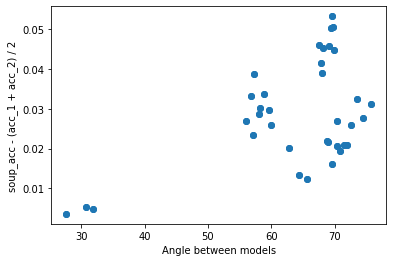

In [28]:
from matplotlib import pyplot as plt

np_results = np.array(results)

plt.scatter(np_results[:, 1] / np.pi * 180, np_results[:, 0])

plt.xlabel('Angle between models')
plt.ylabel('soup_acc - (acc_1 + acc_2) / 2')

## Эксперимент 2

In [51]:
results = []
cnt = 0

transforms_names = ['no_transform', 'with_rotation', 'with_flip']
seeds = [42, 777, 1337]
lrs = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3]

for seed1 in [42]:
    for seed2 in [42]:
        for transform1 in transforms_names:
            for transform2 in transforms_names:
                for lr1 in lrs:
                    for lr2 in lrs:
                        if seed1 == seed2 and lr1 == lr2 and transform1 == transform2:
                            continue
                        
                        max_lr = max(lr1, lr2)
                        model_1 = torch.load(f'./final_models/resnet50_seed_{seed1}_transform_{transform1}_lr_{lr1}.pth').to(device)
                        model_2 = torch.load(f'./final_models/resnet50_seed_{seed2}_transform_{transform2}_lr_{lr2}.pth').to(device)

                        model_soup = uniform_soup([model_1, model_2])

                        acc1 = get_dataset_accuracy(model_soup, test_dataloader, criterion, 'cuda:0')
                        acc2 = get_dataset_ensamble_accuracy([model_1, model_2], test_dataloader, criterion, 'cuda:0')
                        
                        cnt += 1
                        if cnt % 10 == 0:
                            print(f'Done {cnt}!')

                        results += [[acc1, acc2, max_lr]]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Done 10!


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Done 20!


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Done 30!


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Done 40!


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Done 50!


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Done 60!


  0%|          | 0/2 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

Text(0, 0.5, 'Ensamble accuracy')

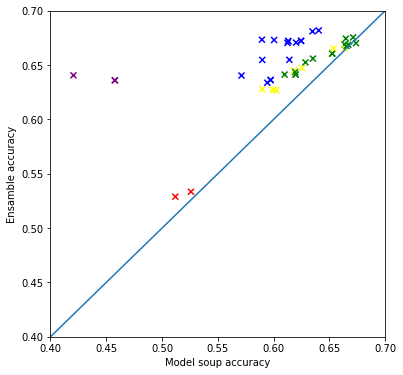

In [52]:
np_results = np.array(results)

lr2clr = {
    1e-5 : 'red',
    5e-5 : 'yellow',
    1e-4 : 'green',
    5e-4 : 'blue',
    1e-3 : 'purple',
}

f = plt.figure()
f.set_figwidth(6)
f.set_figheight(6)

clrs = [lr2clr[i] for i in np_results[:, 2]]
plt.scatter(np_results[:, 0], np_results[:, 1], c=clrs, marker='x')
plt.plot([0, 1], [0, 1])
plt.xlim([0.4, 0.7])
plt.ylim([0.4, 0.7])

plt.xlabel('Model soup accuracy')
plt.ylabel('Ensamble accuracy')

## Эксперимент 3

In [29]:
def greedy_ensamble(models, dataloader, criterion, device):
    used_models = [models[0]]
    loss, current_preds, labels = predict(models[0], dataloader, criterion, device)
    pred_labels = current_preds.argmax(axis=-1)
    current_accuracy = ((pred_labels == labels).sum() / pred_labels.shape[0]).item()
    for i in tqdm(range(1, len(models))):
        loss, preds, labels = predict(models[i], dataloader, criterion, device)
        new_preds = current_preds + preds
        new_pred_labels = new_preds.argmax(axis=-1)
        new_accuracy = ((new_pred_labels == labels).sum() / new_pred_labels.shape[0]).item()
        if new_accuracy > current_accuracy:
            print(f'Use {i}!')
            used_models += [models[i]]
            current_preds = new_preds
            current_accuracy = new_accuracy
    
    return used_models

In [31]:
all_models_with_acc = []

transforms_names = ['no_transform', 'with_rotation', 'with_flip']
seeds = [42, 777, 1337]
lrs = [1e-4, 5e-4, 1e-3]

for seed in seeds:
    for transform in transforms_names:
        for lr in lrs:
            model = torch.load(f'./final_models/resnet50_seed_{seed}_transform_{transform}_lr_{lr}.pth').to(device)
            all_models_with_acc += [(params2acc[f'resnet50_seed_{seed}_transform_{transform}_lr_{lr}.pth'], model)]

all_models = sorted(all_models_with_acc, key=lambda x: -x[0])    
print([x[0] for x in all_models])
all_models = [x[1] for x in all_models]

usoup = uniform_soup(all_models)
gsoup = greedy_soup(all_models, val_dataloader, criterion, device)
gensambe = greedy_ensamble(all_models, val_dataloader, criterion, device)

[0.6534000039100647, 0.6518999934196472, 0.6506999731063843, 0.6482999920845032, 0.6481999754905701, 0.6317999958992004, 0.6312999725341797, 0.628600001335144, 0.6265999674797058, 0.6254000067710876, 0.6222999691963196, 0.6173999905586243, 0.613599956035614, 0.6093999743461609, 0.602400004863739, 0.6013999581336975, 0.5956999659538269, 0.5949999690055847, 0.582099974155426, 0.5724999904632568, 0.5701999664306641, 0.568399965763092, 0.5672999620437622, 0.5658000111579895, 0.5636999607086182, 0.5619999766349792, 0.5450999736785889]


  0%|          | 0/26 [00:00<?, ?it/s]

Use 1!
Use 2!
Use 3!
Use 4!
Use 11!


  0%|          | 0/26 [00:00<?, ?it/s]

Use 1!
Use 2!
Use 4!
Use 5!
Use 7!
Use 9!
Use 10!
Use 12!
Use 13!


In [32]:
print('Best unique model:', max([params2acc[p] for p in params2acc]))
print('Uniform soup:', get_dataset_accuracy(usoup, test_dataloader, criterion, 'cuda:0'))
print('Greedy soup:', get_dataset_accuracy(gsoup, test_dataloader, criterion, 'cuda:0'))
print('Ensamble:', get_dataset_ensamble_accuracy(all_models, test_dataloader, criterion, 'cuda:0'))
print('Greedy ensamble:', get_dataset_ensamble_accuracy(gensambe, test_dataloader, criterion, 'cuda:0'))

Best unique model: 0.6577000021934509
Uniform soup: 0.045099999755620956
Greedy soup: 0.6663999557495117


  0%|          | 0/27 [00:00<?, ?it/s]

Ensamble: 0.725600004196167


  0%|          | 0/10 [00:00<?, ?it/s]

Greedy ensamble: 0.7282999753952026


In [34]:
all_models_with_acc = []

for seed in seeds:
    for transform in transforms_names:
        for lr in [0.0005, 0.0001]:
            model = torch.load(f'./final_models/resnet50_seed_{seed}_transform_{transform}_lr_{lr}.pth').to(device)
            all_models_with_acc += [(params2acc[f'resnet50_seed_{seed}_transform_{transform}_lr_{lr}.pth'], model)]

all_models = sorted(all_models_with_acc, key=lambda x: -x[0])    
print([x[0] for x in all_models])
all_models = [x[1] for x in all_models]

usoup = uniform_soup(all_models)
gsoup = greedy_soup(all_models, val_dataloader, criterion, device)
gensambe = greedy_ensamble(all_models, val_dataloader, criterion, device)

[0.6534000039100647, 0.6518999934196472, 0.6506999731063843, 0.6482999920845032, 0.6481999754905701, 0.6317999958992004, 0.6312999725341797, 0.628600001335144, 0.6265999674797058, 0.6254000067710876, 0.6222999691963196, 0.6173999905586243, 0.613599956035614, 0.6093999743461609, 0.602400004863739, 0.6013999581336975, 0.5956999659538269, 0.5949999690055847]


  0%|          | 0/17 [00:00<?, ?it/s]

Use 1!
Use 2!
Use 3!
Use 4!
Use 11!


  0%|          | 0/17 [00:00<?, ?it/s]

Use 1!
Use 2!
Use 4!
Use 5!
Use 7!
Use 9!
Use 10!
Use 12!
Use 13!


In [35]:
print('Best unique model:', max([params2acc[p] for p in params2acc]))
print('Uniform soup:', get_dataset_accuracy(usoup, test_dataloader, criterion, 'cuda:0'))
print('Greedy soup:', get_dataset_accuracy(gsoup, test_dataloader, criterion, 'cuda:0'))
print('Ensamble:', get_dataset_ensamble_accuracy(all_models, test_dataloader, criterion, 'cuda:0'))
print('Greedy ensamble:', get_dataset_ensamble_accuracy(gensambe, test_dataloader, criterion, 'cuda:0'))

Best unique model: 0.6577000021934509
Uniform soup: 0.5026000142097473
Greedy soup: 0.6663999557495117


  0%|          | 0/18 [00:00<?, ?it/s]

Ensamble: 0.7250999808311462


  0%|          | 0/10 [00:00<?, ?it/s]

Greedy ensamble: 0.7282999753952026


In [36]:
all_models_with_acc = []

for seed in seeds:
    for transform in transforms_names:
        for lr in [0.0001]:
            model = torch.load(f'./final_models/resnet50_seed_{seed}_transform_{transform}_lr_{lr}.pth').to(device)
            all_models_with_acc += [(params2acc[f'resnet50_seed_{seed}_transform_{transform}_lr_{lr}.pth'], model)]

all_models = sorted(all_models_with_acc, key=lambda x: -x[0])    
print([x[0] for x in all_models])
all_models = [x[1] for x in all_models]

usoup = uniform_soup(all_models)
gsoup = greedy_soup(all_models, val_dataloader, criterion, device)
gensambe = greedy_ensamble(all_models, val_dataloader, criterion, device)

[0.6534000039100647, 0.6518999934196472, 0.6506999731063843, 0.6482999920845032, 0.6481999754905701, 0.6317999958992004, 0.6312999725341797, 0.6265999674797058, 0.6173999905586243]


  0%|          | 0/8 [00:00<?, ?it/s]

Use 1!
Use 2!
Use 3!
Use 4!
Use 8!


  0%|          | 0/8 [00:00<?, ?it/s]

Use 1!
Use 2!
Use 4!
Use 5!


In [37]:
print('Best unique model:', max([params2acc[p] for p in params2acc]))
print('Uniform soup:', get_dataset_accuracy(usoup, test_dataloader, criterion, 'cuda:0'))
print('Greedy soup:', get_dataset_accuracy(gsoup, test_dataloader, criterion, 'cuda:0'))
print('Ensamble:', get_dataset_ensamble_accuracy(all_models, test_dataloader, criterion, 'cuda:0'))
print('Greedy ensamble:', get_dataset_ensamble_accuracy(gensambe, test_dataloader, criterion, 'cuda:0'))

Best unique model: 0.6577000021934509
Uniform soup: 0.6639999747276306
Greedy soup: 0.6663999557495117


  0%|          | 0/9 [00:00<?, ?it/s]

Ensamble: 0.6984999775886536


  0%|          | 0/5 [00:00<?, ?it/s]

Greedy ensamble: 0.7003999948501587


In [44]:
all_models_with_acc = []

for seed in [42]:
    for transform in transforms_names:
        for lr in [1e-5, 5e-5, 1e-4]:
            model = torch.load(f'./final_models/resnet50_seed_{seed}_transform_{transform}_lr_{lr}.pth').to(device)
            all_models_with_acc += [(params2acc[f'resnet50_seed_{seed}_transform_{transform}_lr_{lr}.pth'], model)]

all_models = sorted(all_models_with_acc, key=lambda x: -x[0])    
print([x[0] for x in all_models])
all_models = [x[1] for x in all_models]

usoup = uniform_soup(all_models)
gsoup = greedy_soup(all_models, val_dataloader, criterion, device)
gensambe = greedy_ensamble(all_models, val_dataloader, criterion, device)

[0.6577000021934509, 0.6532999873161316, 0.6506999731063843, 0.6481999754905701, 0.6317999958992004, 0.6292999982833862, 0.5288000106811523, 0.5157999992370605, 0.4984999895095825]


  0%|          | 0/8 [00:00<?, ?it/s]

Use 5!


  0%|          | 0/8 [00:00<?, ?it/s]

Use 1!
Use 5!


In [45]:
print('Best unique model:', max([params2acc[p] for p in params2acc]))
print('Uniform soup:', get_dataset_accuracy(usoup, test_dataloader, criterion, 'cuda:0'))
print('Greedy soup:', get_dataset_accuracy(gsoup, test_dataloader, criterion, 'cuda:0'))
print('Ensamble:', get_dataset_ensamble_accuracy(all_models, test_dataloader, criterion, 'cuda:0'))
print('Greedy ensamble:', get_dataset_ensamble_accuracy(gensambe, test_dataloader, criterion, 'cuda:0'))

Best unique model: 0.6577000021934509
Uniform soup: 0.6413999795913696
Greedy soup: 0.663599967956543


  0%|          | 0/9 [00:00<?, ?it/s]

Ensamble: 0.6825999617576599


  0%|          | 0/3 [00:00<?, ?it/s]

Greedy ensamble: 0.6771000027656555
